# DLP PROJECT

#SENTIMENT ANALYSIS USING TRANSFORMERS

In [1]:
!pip install transformers==4.37.0


In [2]:
!pip install ktrain

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
le = LabelEncoder()
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import missingno as  msno
import seaborn as sns
import plotly.graph_objects as go
#import plotly.express as px
import matplotlib.pyplot as plt
import spacy

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
import ktrain
from ktrain import text

from collections import Counter
import missingno as miss
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
from tqdm import tqdm
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, MaxPooling1D, Conv1D, Concatenate, Bidirectional, GlobalMaxPool1D, ActivityRegularization, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix

In [4]:
df = pd.read_csv("all-data (1).csv", encoding='latin-1', header = None)
df.columns = ["Sentiment", "News Headline"]
df.head()

,Sentiment,News Headline
0,positive,Vacon 's cash flow from operations grew to EUR...
1,neutral,Vacon will supply drives to Ruselprom in the p...
2,positive,We also strengthen our existing partnership wi...
3,positive,"Via the Satlan acquisition , Teleste plans to ..."
4,positive,"With the acquisition , the company will expand..."


In [5]:
df.isna().sum()


Sentiment        0
News Headline    0
dtype: int64

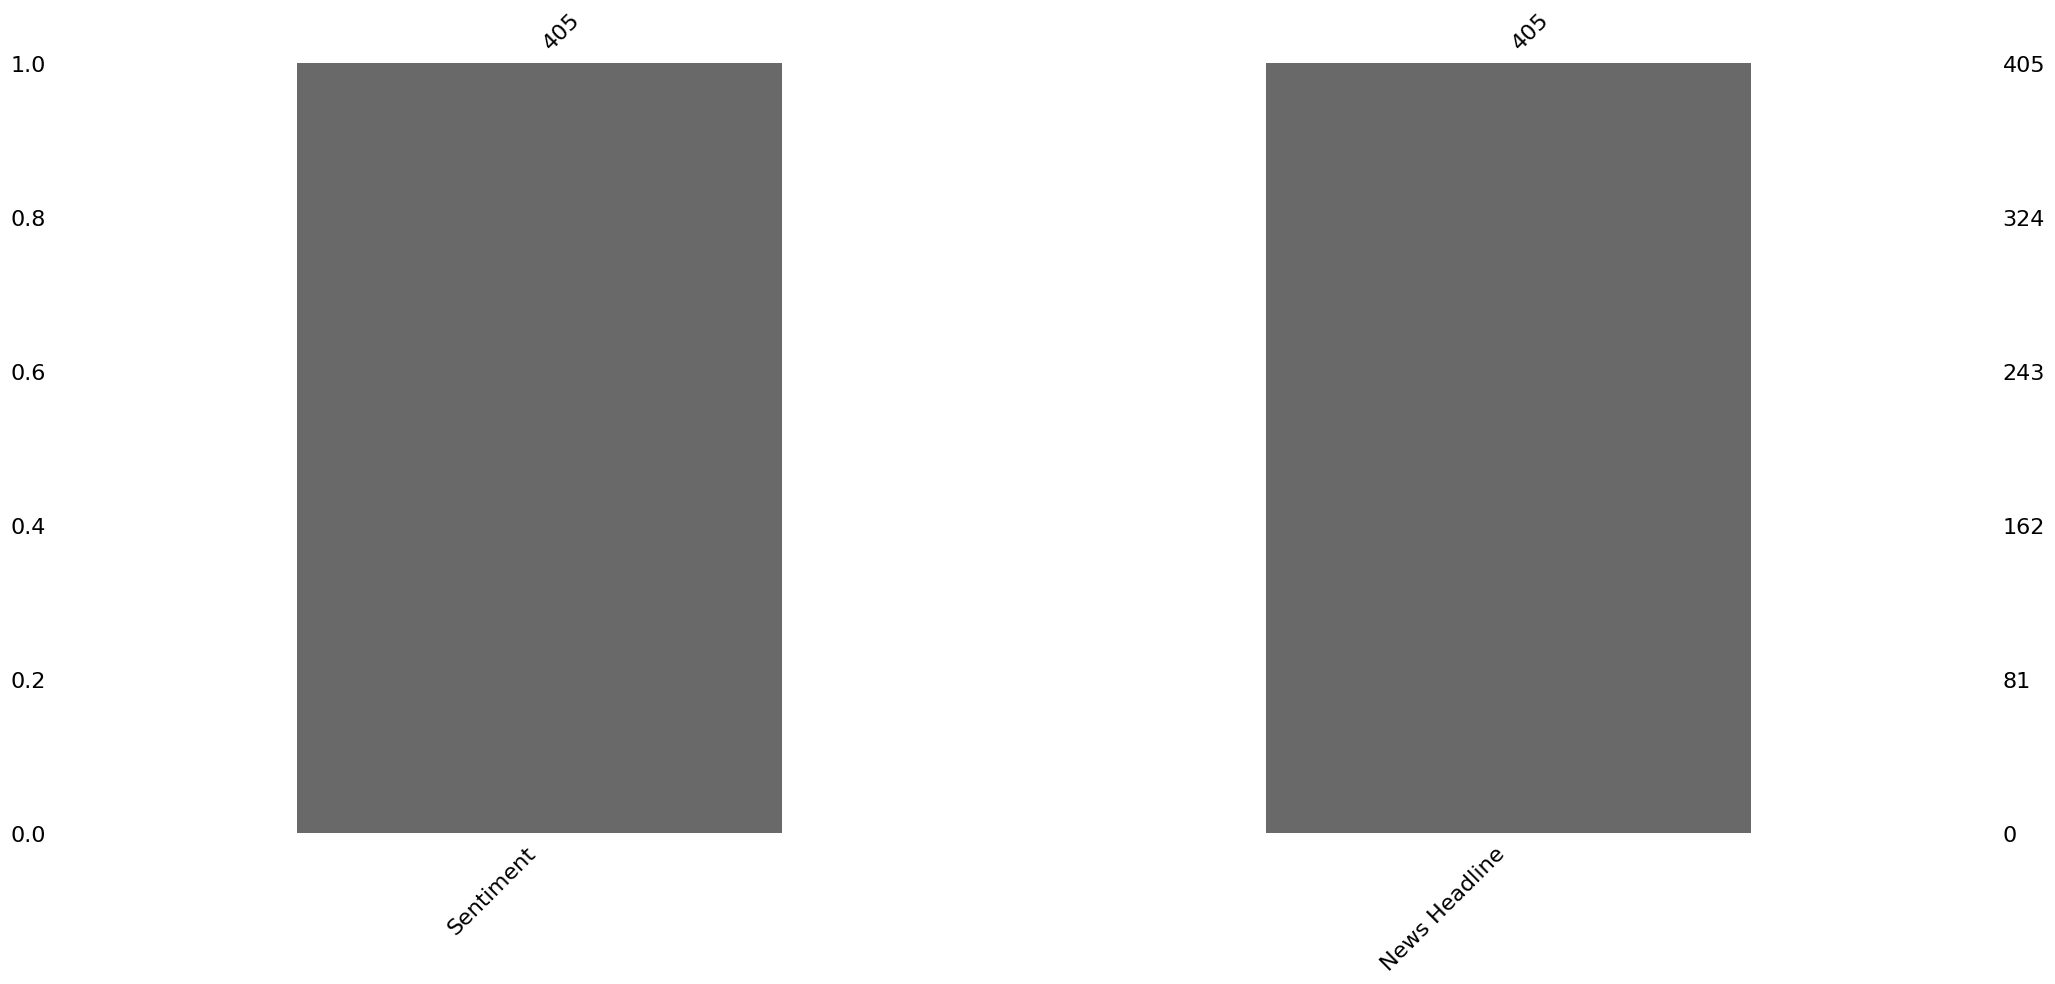

In [6]:
miss.bar(df)
plt.show()

In [7]:
len(df[df.duplicated()])

19

In [8]:
df = df.drop_duplicates()
print(df.head())
print(df.shape)

  Sentiment                                      News Headline
0  positive  Vacon 's cash flow from operations grew to EUR...
1   neutral  Vacon will supply drives to Ruselprom in the p...
2  positive  We also strengthen our existing partnership wi...
3  positive  Via the Satlan acquisition , Teleste plans to ...
4  positive  With the acquisition , the company will expand...
(386, 2)


In [9]:
import re
import spacy
nlp = spacy.load('en_core_web_sm')

def normalize(msg):

    msg = re.sub('[^A-Za-z]+', ' ', msg)

    doc = nlp(msg)

    res=[]

    for token in doc:
        if(token.is_stop or token.is_punct or token.is_currency or token.is_space or len(token.text) <= 2):
            pass
        else:
            res.append(token.lemma_.lower())
    return res

In [10]:
df["News Headline"] = df["News Headline"].apply(normalize)

In [11]:
df.head()

,Sentiment,News Headline
0,positive,"[vacon, cash, flow, operation, grow, eur, eur,..."
1,neutral,"[vacon, supply, drive, ruselprom, power, range]"
2,positive,"[strengthen, exist, partnership, cybercom, say..."
3,positive,"[satlan, acquisition, teleste, plan, expand, m..."
4,positive,"[acquisition, company, expand, offering, north..."


In [12]:
df["News"] = df["News Headline"].apply(lambda x : " ".join(x))

df = df[["News", "Sentiment"]]

df["Sentiment"] = le.fit_transform(df["Sentiment"])

df.head()

,News,Sentiment
0,vacon cash flow operation grow eur eur year ago,2
1,vacon supply drive ruselprom power range,1
2,strengthen exist partnership cybercom say tele...,2
3,satlan acquisition teleste plan expand market ...,2
4,acquisition company expand offering north cent...,2


In [13]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df,
                                                                    'News',
                                                                    label_columns=['Sentiment'],
                                                                   maxlen=100,
                                                                    preprocess_mode='bert')

['Sentiment_0', 'Sentiment_1', 'Sentiment_2']
     Sentiment_0  Sentiment_1  Sentiment_2
70           0.0          0.0          1.0
402          1.0          0.0          0.0
237          0.0          0.0          1.0
166          0.0          1.0          0.0
90           0.0          0.0          1.0
['Sentiment_0', 'Sentiment_1', 'Sentiment_2']
     Sentiment_0  Sentiment_1  Sentiment_2
147          0.0          0.0          1.0
202          0.0          1.0          0.0
294          0.0          1.0          0.0
245          0.0          0.0          1.0
258          0.0          0.0          1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [14]:
model = text.text_classifier(name='bert',
                             train_data=(x_train, y_train),
                             preproc=preproc)

Is Multi-Label? False
maxlen is 100
done.


In [15]:
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=6)

In [16]:
learner.fit_onecycle(lr=2e-5,
                     epochs=3)




begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
58/58 [==============================] - 532s 9s/step - loss: 1.0973 - accuracy: 0.4409 - val_loss: 0.8710 - val_accuracy: 0.5385
Epoch 2/3
58/58 [==============================] - 521s 9s/step - loss: 0.8863 - accuracy: 0.6052 - val_loss: 0.8905 - val_accuracy: 0.5897
Epoch 3/3
58/58 [==============================] - 491s 8s/step - loss: 0.4837 - accuracy: 0.8184 - val_loss: 0.7763 - val_accuracy: 0.6923


In [17]:
import ktrain
from ktrain import text

label_map = {'Sentiment_0': 'negative', 'Sentiment_1': 'neutral', 'Sentiment_2': 'positive'}

sample_text = "I love this product! It's amazing."

predictor = ktrain.get_predictor(learner.model, preproc)


numeric_prediction = predictor.predict(sample_text)
print(numeric_prediction)
sentiment_name = label_map[numeric_prediction]


print("Predicted sentiment:", sentiment_name)

Sentiment_2
Predicted sentiment: positive


In [18]:
text_samples = df["News"].head(10).to_list()

predictor = ktrain.get_predictor(learner.model, preproc)

predictions = []
sentiment_names = []
ratings = []

for i, text in enumerate(text_samples):
    
    result = predictor.predict(text, return_proba=True)
    numeric_prediction = result.argmax()
    sentiment_name = label_map[predictor.get_classes()[numeric_prediction]]

    proba = result.tolist()

    highest_prob = max(proba)
    if sentiment_name == 'neutral':
        rating = None  
    else:
        rating = 1 + int(10 * (highest_prob - 0.5))
        rating = min(max(rating, 1), 5)

    predictions.append(numeric_prediction)
    sentiment_names.append(sentiment_name)
    ratings.append(rating)

    print(f"Sample {i+1} - Text: '{text}'")
    print(f"  Predicted sentiment: {sentiment_name}")
    print(f"  Probabilities [negative, neutral, positive]: {proba}")
    if sentiment_name != 'neutral':
        print(f"  Rating: {sentiment_name} - {rating}")
    else:
        print("  Rating: Neutral")
    print("=" * 20)  


Sample 1 - Text: 'vacon cash flow operation grow eur eur year ago'
  Predicted sentiment: positive
  Probabilities [negative, neutral, positive]: [0.044129639863967896, 0.01728932000696659, 0.938581109046936]
  Rating: positive - 5
Sample 2 - Text: 'vacon supply drive ruselprom power range'
  Predicted sentiment: neutral
  Probabilities [negative, neutral, positive]: [0.031140973791480064, 0.857494056224823, 0.1113649234175682]
  Rating: Neutral
Sample 3 - Text: 'strengthen exist partnership cybercom say teleste cto esko myllyla'
  Predicted sentiment: positive
  Probabilities [negative, neutral, positive]: [0.046406716108322144, 0.009401053190231323, 0.9441922307014465]
  Rating: positive - 5
Sample 4 - Text: 'satlan acquisition teleste plan expand market presence video service partner cable operator broadcaster iptv service provider'
  Predicted sentiment: positive
  Probabilities [negative, neutral, positive]: [0.027265312150120735, 0.02229171246290207, 0.9504429697990417]
  Rating:

In [19]:
import ktrain
from ktrain import text

label_map = {'Sentiment_0': 'negative', 'Sentiment_1': 'neutral', 'Sentiment_2': 'positive'}

sample_text = "I love this product! It's amazing."

predictor = ktrain.get_predictor(learner.model, preproc)

result = predictor.predict(sample_text, return_proba=True)

numeric_prediction = result.argmax()

sentiment_name = label_map[predictor.get_classes()[numeric_prediction]]

proba = result.tolist()

highest_prob = max(proba)

if sentiment_name == 'neutral':
    rating = None  
else:
    rating = 1 + int(10 * (highest_prob - 0.5))
    rating = min(max(rating, 1), 5)

print("Predicted sentiment:", sentiment_name)
print("Probabilities [negative, neutral, positive]:", proba)
if sentiment_name != 'neutral':
    print("Rating:", sentiment_name, rating)
else:
    print("Sentiment is Neutral")


Predicted sentiment: positive
Probabilities [negative, neutral, positive]: [0.15674419701099396, 0.41640934348106384, 0.4268464744091034]
Rating: positive 1


In [20]:
train,val, preproc2 = text.texts_from_df(df,
                                                               'News',
                                                                    label_columns=['Sentiment'],
                                                                   maxlen=350,
                                                                    preprocess_mode='distilbert')



['Sentiment_0', 'Sentiment_1', 'Sentiment_2']
     Sentiment_0  Sentiment_1  Sentiment_2
388          1.0          0.0          0.0
321          0.0          1.0          0.0
218          0.0          0.0          1.0
222          0.0          0.0          1.0
210          0.0          0.0          1.0
['Sentiment_0', 'Sentiment_1', 'Sentiment_2']
     Sentiment_0  Sentiment_1  Sentiment_2
86           0.0          1.0          0.0
306          0.0          1.0          0.0
236          0.0          0.0          1.0
98           0.0          1.0          0.0
27           0.0          0.0          1.0


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 12
	95percentile : 22
	99percentile : 24


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 12
	95percentile : 23
	99percentile : 28


In [21]:
model2 = text.text_classifier(name='distilbert', train_data=train, preproc=preproc2)



Is Multi-Label? False
maxlen is 350
done.


In [22]:

learner2 = ktrain.get_learner(model=model2,
                             train_data=(train),
                             val_data=(val),
                             batch_size=6)

In [23]:
learner2.fit_onecycle(lr=2e-5,
                     epochs=3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
58/58 [==============================] - 869s 15s/step - loss: 1.0378 - accuracy: 0.5043 - val_loss: 0.9474 - val_accuracy: 0.4872
Epoch 2/3
58/58 [==============================] - 836s 14s/step - loss: 0.8276 - accuracy: 0.5764 - val_loss: 0.7398 - val_accuracy: 0.5897
Epoch 3/3
58/58 [==============================] - 835s 14s/step - loss: 0.4507 - accuracy: 0.8790 - val_loss: 0.7147 - val_accuracy: 0.7179
